### GradCAM
1. GradCAM
$$\alpha_k^c=\frac{1}{N}\sum_{i,j}\frac{\partial y^c}{\partial w_{ij}^k}$$
로 각 Feature Map에 대해서 기여도를 곱해서 더한다.  
필터 크기와 같은 Map이 나오게 되지만 이 UpSampling하여 GradCAM을 얻어낸다.

In [1]:
import torch
from PIL import Image
from torchvision import transforms, models
import matplotlib.pyplot as plt
from glob import glob
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


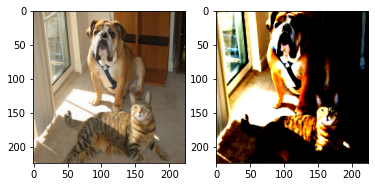

In [2]:
input_image = Image.open(glob('../Data/img/cat_dog.png')[0])
plt.subplot(121)
plt.imshow(input_image)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
plt.subplot(122)
plt.imshow(input_tensor.permute(1,2,0))

In [68]:
model.eval()
torch.argmax(model(input_tensor.unsqueeze(0).to('cuda')).squeeze(0))

tensor(254, device='cuda:0')

(224, 224, 3)


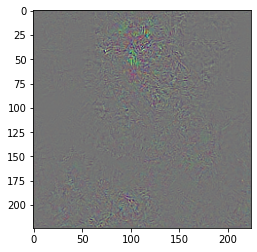

In [69]:
class VanillaBP():
    def __init__(self, model):
        self.model = model
    def backward_hook(self,_,grad_input,grad_output):
        self.grad = grad_input[0]
    def output(self, img_tensor, target_class):
        self.model.zero_grad()
        input_batch = img_tensor.unsqueeze(0).to('cuda')
        input_batch.requires_grad_()
        pred = self.model(input_batch).squeeze(0)
        pred[target_class].backward()
        output = input_batch.grad.squeeze(0).cpu()
#         output = self.grad.squeeze(0).cpu()
        output = output-output.min()
        output = output/output.max()
        return output.permute(1,2,0).detach().numpy()
model = models.vgg16(pretrained=True)
model.to('cuda')
model.zero_grad()
vanillaBP = VanillaBP(model)
vanilla =vanillaBP.output(input_tensor,254)
print(vanilla.shape)
plt.imshow(vanilla)

(224, 224, 3)


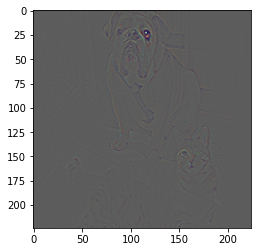

In [7]:
class GuidedBP():
    def __init__(self,model):
        self.model = model
        self.forward_input = []
        for module in model.modules():
            if module.__class__.__name__ =="ReLU":
                module.register_backward_hook(self.backward_hook)
    def backward_hook(self,_, grad_input, grad_output):
        #grad_input: tuple, grad_output: tuple
        return ((grad_output[0] > 0)* grad_input[0],)
    def output(self,img_tensor, target_class):
        self.model.zero_grad()
        input_batch = img_tensor.unsqueeze(0).to('cuda')
        input_batch.requires_grad_()
        pred = self.model(input_batch).squeeze(0)
        pred[target_class].backward()
        output = input_batch.grad.squeeze(0).cpu()
        output = output-output.min()
        output = output/output.max()
        return output.permute(1,2,0).detach().numpy()
model = models.vgg16(pretrained=True)
model.to('cuda')
model.zero_grad()
guidedBP = GuidedBP(model)
guided = guidedBP.output(input_tensor,254)
print(guided.shape)
plt.imshow(guided)

In [11]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models
class GradCAM():
    def __init__(self, model,layer):
        self.model = model
        self.layer =layer
        layer.register_forward_hook(self.forward_hook)
        layer.register_backward_hook(self.backward_hook)
    def forward_hook(self,_,input,output):
        self.output = output[0]
    def backward_hook(self,_,grad_input,grad_output):
        self.grad_output = grad_output[0]
    def output(self,input_tensor ,target_class=-1):
        self.model.zero_grad()
        self.model.eval()
        self.target_class = target_class
        input_batch =input_tensor.unsqueeze(0)
        pred = self.model(input_batch)
        if target_class is -1:
            self.target_class = torch.argmax(pred)
        pred.squeeze(0)[self.target_class].backward()
        alpha_k = torch.sum(self.grad_output.squeeze(0),dim=(1,2),keepdim=True)
        output = torch.sum(alpha_k*self.output,dim=0,keepdim= True).cpu().unsqueeze(0)
        output = torch.nn.functional.relu(output)
        m = torch.nn.Upsample(scale_factor=16, mode='bilinear')
        output = m(output).squeeze()
        output = (output - torch.min(output))/(torch.max(output)-torch.min(output))
        return output.detach().numpy()